In [1]:
from time import time

start = time()

## Regex classifier

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import re


#idea credit https://www.linkedin.com/pulse/regex-one-pattern-rule-them-all-find-bring-darkness-bind-carranza/
class RegexClassifier(BaseEstimator, RegressorMixin):
    """
    Language Classifier using Regular Expressions
    """

    language_regex_dict = {
        'el': r'([\u0370-\u03FF]+)\s?',  # Greek
        'en': r'([a-zA-Z]+)\s?',  # English
    }

    # STATIC INITALIZATION BLOCK
    # pre-compie all expressions to save execution time
    for lang in language_regex_dict.keys():
        language_regex_dict[lang] = re.compile(language_regex_dict[lang])


    def __init__(self, include_greeklish=True):
        """
        Initialize a new :class:`RegexClassifier` instance.

        :param include_greeklish: Optional. If True, include Greeklish in the language identification process.
        """
        self.include_greeklish = include_greeklish

    def predict(self, x):
        preds = []

        for text in x:
            pred = "other"

            if self.include_greeklish and \
                re.search(RegexClassifier.language_regex_dict["el"], text) and \
                re.search(RegexClassifier.language_regex_dict["en"], text):
                    pred = "greeklish"

            for lang_code, regex_pattern in RegexClassifier.language_regex_dict.items():
                match = re.search(regex_pattern, text)
                if match:
                    pred = lang_code
                    break
            preds.append(pred)
        return np.array(preds)
    
    def fit(self, x, y):
        return self

In [3]:
# Example usage
user_input_text = ["你好，これはサンプルです。안녕하세요", "this is an english sentence", "δεν αντεχω αλλο"]
detected_language = RegexClassifier().predict(user_input_text)
print(f"Detected Language Code: {detected_language}")

Detected Language Code: ['other' 'en' 'el']


## Defining the Gold Standard


### Greek-English identification dataset

https://aclanthology.org/L06-1229/
https://aclanthology.org/L04-1369/
https://huggingface.co/datasets/papluca/language-identification

In [4]:
import pandas as pd


def dataset_to_pd(dataset_dict: dict) -> pd.DataFrame:
    df_ls = []
    label_array = np.empty(shape=(sum([len(dataset) for dataset in dataset_dict.values()])), dtype=object)
    last_idx = -1

    for label, dataset in dataset_dict.items():
        new_last_idx = len(dataset) + last_idx
        label_array.put(np.arange(last_idx+1, new_last_idx+1, 1), label)
        last_idx = new_last_idx

        df_ls.append(pd.DataFrame(dataset))

    full_df = pd.concat(df_ls, ignore_index=True)
    full_df["set"] = label_array
    full_df.insert(0, "set", full_df.pop("set"))

    return full_df

In [5]:
from datasets import load_dataset


dataset_dict = load_dataset("papluca/language-identification")
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [6]:
lang_df = dataset_to_pd(dataset_dict)
lang_df

,set,labels,text
0,train,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,train,bg,размерът на хоризонталната мрежа може да бъде ...
2,train,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,train,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,train,ru,Он увеличил давление .
...,...,...,...
89995,test,zh,史料很充分，对岸的很多观点与大陆迥异啊。
89996,test,tr,"Örneğin, teşhis Yunanca bir kelimeden alındı (..."
89997,test,vi,Nếu lite/light chỉ đơn giản là mô tả một đặc t...
89998,test,bg,"Например, една щатска столица, която посетихме..."


In [7]:
en_gr_cond = lang_df.labels.eq("el") | lang_df.labels.eq("en")
en_gr_df = lang_df.loc[en_gr_cond, ["labels", "text"]]
en_gr_df

,labels,text
18,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
39,en,Didnt really seem to work much.
40,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
49,en,Highly recommend for those who don't like bein...
75,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
89961,en,"It's super cute, really soft. Print is fine bu..."
89965,en,"One of them worked, the other one didn't. Ther..."
89978,en,I only received one out of the three strikers :(
89982,el,Οι οργανισμοί πρέπει να είναι σε θέση να μετρή...


In [8]:
others_df = lang_df.loc[~en_gr_cond, ["labels", "text"]]
others_df = others_df.sample(15000)
others_df.labels = "other"
others_df

,labels,text
40771,other,Rada Bezpieczeństwa ONZ wzywa do humanitarnego...
73391,other,100% recomendable para Samsung Galaxy A5 2017....
22717,other,هل قصة خفض التكلفة معقولة ?
89044,other,"De momento genial, las teclas tienen mucha sen..."
40535,other,คิด 22 ชัดเจน สะท้อน สภาพแวดล้อม ทรัพยากร ...
...,...,...
45284,other,"но те са били първите индианци , които е вижда..."
3393,other,Très Agréable à porter et semble résistant. Pa...
33908,other,Nunca llegó el.producto y ellos procedieron al...
75023,other,Wie geht sie bloß auf??? Ich habe zwei gekauft...


In [9]:
gold1_df = pd.concat([en_gr_df, others_df], axis=0, ignore_index=True, copy=False)
gold1_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
23995,other,"но те са били първите индианци , които е вижда..."
23996,other,Très Agréable à porter et semble résistant. Pa...
23997,other,Nunca llegó el.producto y ellos procedieron al...
23998,other,Wie geht sie bloß auf??? Ich habe zwei gekauft...


### Greek-Greeklish identification dataset

In [10]:
head_url = "https://forum.warmane.com"
warmane_url = "https://forum.warmane.com/forumdisplay.php?f=20"

In [11]:
from src.util import fetch_soup
from tasks.warmane import parse_warmane_thread
from tqdm import tqdm


threads = []

for page in range(1, 9):
    url = warmane_url + f"&page={page}"
    soup = fetch_soup(url)

    print(f"Processing page {page} of 8...")
    thread_tags = soup.find_all("li", {"class": "threadbit"})
    for thread_tag in tqdm(thread_tags):
        thread = parse_warmane_thread(head_url, thread_tag)
        threads.append(thread)

Processing page 1 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.23it/s]


Processing page 2 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.48it/s]


Processing page 3 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.57it/s]


Processing page 4 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.16it/s]


Processing page 5 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.24it/s]


Processing page 6 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.44it/s]


Processing page 7 of 8...


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  5.11it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=272585


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.42it/s]


Processing page 8 of 8...


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:00<00:00,  5.13it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=278731


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.46it/s]


In [12]:
import itertools

# flatten nested lists 
posts = set(itertools.chain.from_iterable([thread.posts for thread in threads]))
len(posts)

414

In [13]:
import pandas as pd

warmane_df = pd.DataFrame.from_records([post.__dict__ for post in posts], index="id")
warmane_df.reply_to = warmane_df.reply_to.fillna(-1).astype(int)
warmane_df

,thread_id,author,contents,date,reply_to
id,,,,,
2926596,384475,Ripsin,"Kalhspera paides,\n\r\nEimai arketo kairo ston...",2018-05-22,-1
2473988,300013,v4gflo,geia sas.psaxnw ellhniko guild ston Deathwing ...,2015-06-17,-1
2420747,290921,AlexPan,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...",2015-03-24,-1
2981903,399822,xAchillesGate4x,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...,2019-03-03,-1
2879517,371804,Csdas,Opoios gnwrizei kati as mou kanei /w Dremoria ...,2017-11-29,-1
...,...,...,...,...,...
2877428,353812,Shiverbro,kalos private aksizei na ksekiniseis paidia?,2017-11-21,2875915
3069941,423611,crystallenia898,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...,2020-07-26,3068345
2801654,350071,Draculation,Bump! ICC25 6/12,2017-05-07,2795443


In [14]:
empty_contents = warmane_df.contents.apply(lambda x: x.isspace() | len(x)==0)
warmane_df[empty_contents]

,thread_id,author,contents,date,reply_to
id,,,,,
3082464,427259,malakas17,,2020-10-20,3081822
3113236,427259,malakas17,,2021-05-12,3113009
3099161,431660,malakas17,,2021-02-10,3096432
3113819,427259,malakas17,,2021-05-16,3113236
3099593,427259,boonick,,2021-02-14,3093400
3081820,427259,malakas17,,2020-10-16,3080427
3081822,427259,malakas17,,2020-10-16,3081820


In [15]:
warmane_df = warmane_df[~empty_contents]

In [16]:
regex_model = RegexClassifier(include_greeklish=False)
preds = regex_model.predict(warmane_df.contents)

In [17]:
warmane_df[preds=="en"].contents

id
2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
2959390               Bubblethesap Icecrown wotlk horde belf
2947119    den se vrisko kane add evvi  .\nmou leei den u...
                                 ...                        
2557881                          Paokara einai padou file :P
2602989    Me to plevro ton Allience ayti ti fora Oi <<An...
2877428         kalos private aksizei na ksekiniseis paidia?
2801654                                     Bump! ICC25 6/12
2873339    Kalhspera tha ithela na rwthsw an kapoios gnwr...
Name: contents, Length: 227, dtype: object

In [18]:
warmane_df[preds=="greeklish"].contents

Series([], Name: contents, dtype: object)

In [19]:
warmane_df[preds=="el"].contents

id
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2959391    Καλησπερα θα πας στις ιδιότητες (properties) σ...
2719776    Originally Posted by celphecil\n\nΚαλησπέρα Σω...
2971700    Ελληνικο guild , ψαχνουμε ατομα για runs ICC10...
                                 ...                        
2609122    πώρωση με τα μισά Dung, Quests και Raids bugge...
2707437    Λοιπόν μαγες,ξέρει κάποιος γιατί δεν γίνεται ν...
2777071    INACTIVE\n\n\n <Northern Defiance>  Καινούργια...
3069941    Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2410495    Εμπειρια εχω, αλλα δεν εχω χρονο...αυτο ειναι ...
Name: contents, Length: 180, dtype: object

In [20]:
labels = np.where(preds=="en", "greeklish", "el")
gold2_df = pd.DataFrame({"labels": labels, "text": warmane_df.contents})
gold2_df

,labels,text
id,,
2926596,greeklish,"Kalhspera paides,\n\r\nEimai arketo kairo ston..."
2473988,greeklish,geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747,el,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \..."
2981903,el,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517,greeklish,Opoios gnwrizei kati as mou kanei /w Dremoria ...
...,...,...
2877428,greeklish,kalos private aksizei na ksekiniseis paidia?
3069941,el,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2801654,greeklish,Bump! ICC25 6/12


In [21]:
gold_df = pd.concat([gold1_df, gold2_df])
gold_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
2877428,greeklish,kalos private aksizei na ksekiniseis paidia?
3069941,el,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2801654,greeklish,Bump! ICC25 6/12
2873339,greeklish,Kalhspera tha ithela na rwthsw an kapoios gnwr...


In [22]:
import os


OUTPUT_DIR = "output"

def csv_output(df: pd.DataFrame, filename: str) -> None:
    file = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(file)
    print(f"File saved successfully as {file}")

In [23]:
csv_output(gold_df, "gold.csv")

File saved successfully as output\gold.csv


## Youtube Crawling

In [26]:
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium import webdriver


class ChromeDriverManager:
    """
    A singleton class for managing a Chrome WebDriver instance using Selenium.

    This class ensures that only one instance of the Chrome WebDriver is created
    and provides methods for setting options, getting the instance, and quitting
    the WebDriver when done.

    Usage:
    - To set options, use the `set_options` class method.
    - To obtain the Chrome WebDriver instance, use the `get` class method.
    - To quit and close the Chrome WebDriver instance, use the `quit` class method.
    """
    DRIVER = None
    options = webdriver.ChromeOptions()

    @classmethod
    def set_options(cls, options):
        cls.options = options
        
    @classmethod   
    def get(cls):
        """
        Get the singleton instance of the Chrome WebDriver.

        If the WebDriver instance does not exist, a new one is created using the
        configured options.

        Returns:
        The singleton instance of the Chrome WebDriver.
        """
        if cls.DRIVER is None:
            cls.DRIVER = _new_chrome_driver(cls.options)
        return cls.DRIVER

    @classmethod  
    def quit(cls):
        """
        Quit and close the Chrome WebDriver instance.

        This method should be called when the WebDriver is no longer needed.
        """
        cls.DRIVER.quit()
        cls.DRIVER = None

    def __init__(self):
        """
        Raise an exception to enforce the singleton pattern.

        To obtain the Chrome WebDriver instance, use the `get` class method.
        """
        raise Exception("DriverManager is a singleton. Use DriverManager.get() to get a driver.")

      
def _new_chrome_driver(options):
    try:
        service = Service()
    except Exception:
        service = Service(ChromeDriverManager().install())
        
    return webdriver.Chrome(service=service, options=options)


def default_options():
    """
    Default configuration, featuring headless setup, standard language and user agent settings.
    """
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")
    options.add_argument('--lang=en')
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36")
    return options


def jupyter_options():
    """
    Adds jupyter-specific settings to default_options().
    """
    options = default_options()
    # prevent console spam
    options.add_experimental_option('excludeSwitches', ['enable-logging'])
    return options


ChromeDriverManager.set_options(jupyter_options())

In [27]:
from tasks.youtube import scrape_youtube, extract_search_results, extract_comments


# "greek songs" search in Greek
search_url = "https://www.youtube.com/results?search_query=%CE%B5%CE%BB%CE%BB%CE%B7%CE%BD%CE%B9%CE%BA%CE%B1+%CF%84%CF%81%CE%B1%CE%B3%CE%BF%CF%85%CE%B4%CE%B9%CE%B1"
search_soup = scrape_youtube(ChromeDriverManager.get(), search_url, max_scrolls=10, verbose=True)

Scrolling (0 out of max 10)...
Scrolling (1 out of max 10)...
Scrolling (2 out of max 10)...
Scrolling (3 out of max 10)...
Scrolling (4 out of max 10)...
Scrolling (5 out of max 10)...
Scrolling (6 out of max 10)...
Scrolling (7 out of max 10)...
Scrolling (8 out of max 10)...
Scrolling (9 out of max 10)...
Scrolling (10 out of max 10)...


In [28]:
results = extract_search_results(search_soup)
results_df = pd.DataFrame({"title": results[0], "link": results[1]})
results_df

,title,link
0,"\n\nΠου 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημέ...",/watch?v=OdX0y96UPEA&pp=ygUjzrXOu867zrfOvc65zr...
1,\n\nGreek Hits 2023 | Non-Stop Mix by Elegant ...,/watch?v=RcSAggke-_U&pp=ygUjzrXOu867zrfOvc65zr...
2,\n\nGreek Ultra Hits Non Stop Mix By Nikos Hal...,/watch?v=KhCU68Eok9E&pp=ygUjzrXOu867zrfOvc65zr...
3,\n\nAnastasia - Omorfi | Αναστασία - Όμορφη (O...,/watch?v=f8wpmLCmbas&pp=ygUjzrXOu867zrfOvc65zr...
4,\n\nΜουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χ...,/watch?v=p5g82ta4sTk&pp=ygUjzrXOu867zrfOvc65zr...
...,...,...
218,\n\nΧρήστος Μενιδιάτης – Από Σήμερα | Official...,/watch?v=6-UiKOxBXc8&pp=ygUjzrXOu867zrfOvc65zr...
219,\n\nπαιδιά τραγούδια | Ελληνικά Χριστουγεννιάτ...,/watch?v=CoFLfM4beq4&pp=ygUjzrXOu867zrfOvc65zr...
220,\n\nΔιαχρονικά ελληνικά τραγούδια (Σε υψηλή πο...,/watch?v=32ZVcMG70iU&pp=ygUjzrXOu867zrfOvc65zr...
221,\n\nStavento feat. Ήβη Αδάμου - Για Σένα (Offi...,/watch?v=mYkJ-Hrw1LA&pp=ygUjzrXOu867zrfOvc65zr...


In [29]:
results_df.title = results_df.title.apply(lambda x: x.strip())
results_df.link = results_df.link.apply(lambda x: "https://www.youtube.com" + x) 
results_df

,title,link
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...
1,Greek Hits 2023 | Non-Stop Mix by Elegant Gree...,https://www.youtube.com/watch?v=RcSAggke-_U&pp...
2,Greek Ultra Hits Non Stop Mix By Nikos Halkous...,https://www.youtube.com/watch?v=KhCU68Eok9E&pp...
3,Anastasia - Omorfi | Αναστασία - Όμορφη (Offic...,https://www.youtube.com/watch?v=f8wpmLCmbas&pp...
4,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...
...,...,...
218,Χρήστος Μενιδιάτης – Από Σήμερα | Official Mus...,https://www.youtube.com/watch?v=6-UiKOxBXc8&pp...
219,παιδιά τραγούδια | Ελληνικά Χριστουγεννιάτικα ...,https://www.youtube.com/watch?v=CoFLfM4beq4&pp...
220,Διαχρονικά ελληνικά τραγούδια (Σε υψηλή ποιότη...,https://www.youtube.com/watch?v=32ZVcMG70iU&pp...
221,Stavento feat. Ήβη Αδάμου - Για Σένα (Official...,https://www.youtube.com/watch?v=mYkJ-Hrw1LA&pp...


In [30]:
greeklish_model = RegexClassifier(include_greeklish=True)
preds = greeklish_model.predict(results_df.title)
gr_res_df = results_df[(preds != "en") & (preds != None)]
gr_res_df

,title,link
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...
3,Anastasia - Omorfi | Αναστασία - Όμορφη (Offic...,https://www.youtube.com/watch?v=f8wpmLCmbas&pp...
4,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...
5,Αντώνης Ρέμος - Χίλια Σπίρτα - Official Music ...,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...
6,"Τα λαϊκά της ταβέρνας Νο.2 - 90 αξέχαστα, αυθε...",https://www.youtube.com/watch?v=VrxTxAByQW4&pp...
...,...,...
218,Χρήστος Μενιδιάτης – Από Σήμερα | Official Mus...,https://www.youtube.com/watch?v=6-UiKOxBXc8&pp...
219,παιδιά τραγούδια | Ελληνικά Χριστουγεννιάτικα ...,https://www.youtube.com/watch?v=CoFLfM4beq4&pp...
220,Διαχρονικά ελληνικά τραγούδια (Σε υψηλή ποιότη...,https://www.youtube.com/watch?v=32ZVcMG70iU&pp...
221,Stavento feat. Ήβη Αδάμου - Για Σένα (Official...,https://www.youtube.com/watch?v=mYkJ-Hrw1LA&pp...


In [31]:
import bs4
import threading


def scrape_job(yt_url: str) -> tuple[str, bs4.BeautifulSoup]:
    # access global driver object
    try:
        result = scrape_youtube(ChromeDriverManager.get(), 
                                yt_url, 
                                scroll_wait_secs=2,
                                max_scrolls=15,
                                verbose=False)
    except Exception:
        result = None
    return yt_url, result

In [32]:
import concurrent.futures


jobs = 15
# get at most max_videos, if more videos were crawled during the search
max_videos = 150
urls = gr_res_df.link[:max_videos] if len(gr_res_df) > max_videos else gr_res_df

print("Scrapping comments...")
with concurrent.futures.ThreadPoolExecutor(max_workers=jobs) as executor:
    results = list(tqdm(executor.map(scrape_job, urls), total=len(urls)))

ChromeDriverManager.quit()

Scrapping comments...


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [05:18<00:00,  2.13s/it]


In [33]:
from tasks.youtube import extract_comments


scraped_urls = []
comments = []
dates = []

for url, result in results:
    if result is not None:
        new_comments, new_dates = extract_comments(result)
        comments += new_comments
        dates += new_dates
        scraped_urls += ([url] * len(new_comments))

In [34]:
comments_df = pd.DataFrame({"link": scraped_urls, "text": comments, "date": dates})
comments_df

,link,text,date
0,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,The most beautiful country in the world!\nSerb...,2022-11-25 11:39:51.936919
1,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Прелепи Скијатос и прелепа Грчка. Пуно поздрав...,2021-11-25 11:39:51.941927
2,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,"Phenomenal songs, enjoyed a lot! Thank you Gre...",2023-02-25 11:39:51.948242
3,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,This mix is definitely one of the best I’ve he...,2021-11-25 11:39:51.951241
4,https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,I'd love to live in Greece one day.....love th...,2021-11-25 11:39:51.955497
...,...,...,...
4323,https://www.youtube.com/watch?v=rkb7hgYqcDk&pp...,μμμμ,2020-11-25 11:40:12.419526
4324,https://www.youtube.com/watch?v=rkb7hgYqcDk&pp...,Κυριε δημητρη αμα ειστε μεσα στο σπιτι σας ν...,2023-03-25 11:40:12.423574
4325,https://www.youtube.com/watch?v=rkb7hgYqcDk&pp...,Ικ,2020-11-25 11:40:12.425860
4326,https://www.youtube.com/watch?v=rkb7hgYqcDk&pp...,Επιτέλους ποιότητα!!,2023-06-25 11:40:12.430896


In [35]:
crawl_df = pd.merge(gr_res_df, comments_df, how="inner", on="link")
crawl_df

,title,link,text,date
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,The most beautiful country in the world!\nSerb...,2022-11-25 11:39:51.936919
1,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Прелепи Скијатос и прелепа Грчка. Пуно поздрав...,2021-11-25 11:39:51.941927
2,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,"Phenomenal songs, enjoyed a lot! Thank you Gre...",2023-02-25 11:39:51.948242
3,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,This mix is definitely one of the best I’ve he...,2021-11-25 11:39:51.951241
4,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,I'd love to live in Greece one day.....love th...,2021-11-25 11:39:51.955497
...,...,...,...,...
4422,ΤΡΑΓΟΥΔΙΑ ΠΟΥ ΑΓΑΠΗΣΑΜΕ (ΕΠΙΛΟΓΕΣ),https://www.youtube.com/watch?v=rkb7hgYqcDk&pp...,μμμμ,2020-11-25 11:40:12.419526
4423,ΤΡΑΓΟΥΔΙΑ ΠΟΥ ΑΓΑΠΗΣΑΜΕ (ΕΠΙΛΟΓΕΣ),https://www.youtube.com/watch?v=rkb7hgYqcDk&pp...,Κυριε δημητρη αμα ειστε μεσα στο σπιτι σας ν...,2023-03-25 11:40:12.423574
4424,ΤΡΑΓΟΥΔΙΑ ΠΟΥ ΑΓΑΠΗΣΑΜΕ (ΕΠΙΛΟΓΕΣ),https://www.youtube.com/watch?v=rkb7hgYqcDk&pp...,Ικ,2020-11-25 11:40:12.425860
4425,ΤΡΑΓΟΥΔΙΑ ΠΟΥ ΑΓΑΠΗΣΑΜΕ (ΕΠΙΛΟΓΕΣ),https://www.youtube.com/watch?v=rkb7hgYqcDk&pp...,Επιτέλους ποιότητα!!,2023-06-25 11:40:12.430896


In [36]:
sum(crawl_df.date != None)

4427

In [37]:
crawl_df[crawl_df.text.apply(lambda x: x.isspace())]

,title,link,text,date


In [38]:
preds = greeklish_model.predict(crawl_df.text)
mask = (preds != "el") & (preds != "greeklish")
crawl_df[mask]

,title,link,text,date
0,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,The most beautiful country in the world!\nSerb...,2022-11-25 11:39:51.936919
1,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,Прелепи Скијатос и прелепа Грчка. Пуно поздрав...,2021-11-25 11:39:51.941927
2,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,"Phenomenal songs, enjoyed a lot! Thank you Gre...",2023-02-25 11:39:51.948242
3,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,This mix is definitely one of the best I’ve he...,2021-11-25 11:39:51.951241
4,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...,I'd love to live in Greece one day.....love th...,2021-11-25 11:39:51.955497
...,...,...,...,...
4416,ΤΡΑΓΟΥΔΙΑ ΠΟΥ ΑΓΑΠΗΣΑΜΕ (ΕΠΙΛΟΓΕΣ),https://www.youtube.com/watch?v=rkb7hgYqcDk&pp...,,2023-08-25 11:40:12.397540
4418,ΤΡΑΓΟΥΔΙΑ ΠΟΥ ΑΓΑΠΗΣΑΜΕ (ΕΠΙΛΟΓΕΣ),https://www.youtube.com/watch?v=rkb7hgYqcDk&pp...,,2020-11-25 11:40:12.404305
4419,ΤΡΑΓΟΥΔΙΑ ΠΟΥ ΑΓΑΠΗΣΑΜΕ (ΕΠΙΛΟΓΕΣ),https://www.youtube.com/watch?v=rkb7hgYqcDk&pp...,savvatovrado 2023 pinontas kai akougontas...,2023-08-25 11:40:12.407506
4420,ΤΡΑΓΟΥΔΙΑ ΠΟΥ ΑΓΑΠΗΣΑΜΕ (ΕΠΙΛΟΓΕΣ),https://www.youtube.com/watch?v=rkb7hgYqcDk&pp...,Efkaristo ja afto tragudhja,2023-01-25 11:40:12.412206


In [39]:
csv_output(crawl_df, "crawl.csv")

File saved successfully as output\crawl.csv


## Language Identification

In [40]:
from sklearn.model_selection import train_test_split


data_train, data_test = train_test_split(gold_df, test_size=0.2, 
                                         random_state=42, stratify=gold_df.labels)
data_train

,labels,text
23046,other,Nadal tuimelt in de Franse Open finale
23212,other,Déçu ne fonctionne pas avec 1 Samsung A... dom...
18110,other,انصاف کے لحاظ سے سپریم کورٹ نے اعلان کیا کہ اس...
22530,other,Meest krachtige tyfoon van 2013 raakt de Filip...
10563,other,Он вступил в НАТО в 1952. году .
...,...,...
23007,other,Tovuti ya MCI inaelezea lengo ya kupima mbio h...
23607,other,انا انا انا انتهيت اشاهد الكثير من هذه الاشياء...
17279,other,การประมูล ใน การแข่งขัน ยัง ง่าย ขึ้น ด้วย ชื่...
5066,en,This product was not for dogs. Definitely for ...


In [41]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


vectorizer = TfidfVectorizer().fit(data_train.text)
x_train = vectorizer.transform(data_train.text)
y_train = data_train.labels
x_test = vectorizer.transform(data_test.text)
y_test = data_test.labels

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((19525, 80976), (19525,), (4882, 80976), (4882,))

In [42]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res

### Dummy Classifier

In [43]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings


def get_statistics(y_test, y_pred):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        print(f"Macro F1: {f1_score(y_test, y_pred, average='macro', zero_division=0)}")
        print(classification_report(y_test, y_pred, zero_division=0))
        ConfusionMatrixDisplay.from_predictions(y_test, 
                                                y_pred, 
                                                colorbar=True)
        plt.show()

Macro F1: 0.19030702867292565
              precision    recall  f1-score   support

          el       0.00      0.00      0.00       936
          en       0.00      0.00      0.00       900
   greeklish       0.00      0.00      0.00        46
       other       0.61      1.00      0.76      3000

    accuracy                           0.61      4882
   macro avg       0.15      0.25      0.19      4882
weighted avg       0.38      0.61      0.47      4882



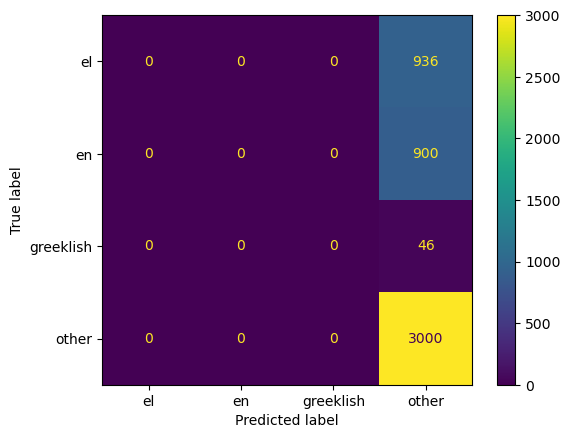

In [44]:
from sklearn.dummy import DummyClassifier, DummyRegressor


majority = DummyClassifier(strategy="most_frequent")
majority.fit(x_train, y_train)
majority_res = majority.predict(x_test)

get_statistics(y_test, majority_res)

### Regex Classification

In [45]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    regex_model = RegexClassifier()
    res = cross_val_res(regex_model, data_train.text, y_train, scoring="f1_macro")
    print(f"Regex Classifier mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Regex Classifier mean macro F1: 0.5040, std: 0.5009


Macro F1: 0.5048806538860134
              precision    recall  f1-score   support

          el       1.00      1.00      1.00       936
          en       0.32      1.00      0.48       900
   greeklish       0.00      0.00      0.00        46
       other       1.00      0.37      0.54      3000

    accuracy                           0.60      4882
   macro avg       0.58      0.59      0.50      4882
weighted avg       0.86      0.60      0.61      4882



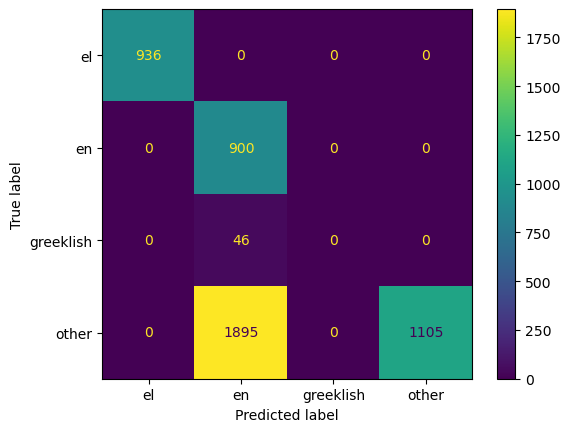

In [46]:
regex_model = RegexClassifier(include_greeklish=True).fit(data_train.text, y_train)
regex_res = regex_model.predict(data_test.text)
get_statistics(y_test, regex_res)

### Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.8140, std: 0.8535


Macro F1: 0.8889742452224132
              precision    recall  f1-score   support

          el       1.00      0.94      0.97       936
          en       0.99      0.97      0.98       900
   greeklish       1.00      0.46      0.63        46
       other       0.97      1.00      0.98      3000

    accuracy                           0.98      4882
   macro avg       0.99      0.84      0.89      4882
weighted avg       0.98      0.98      0.97      4882



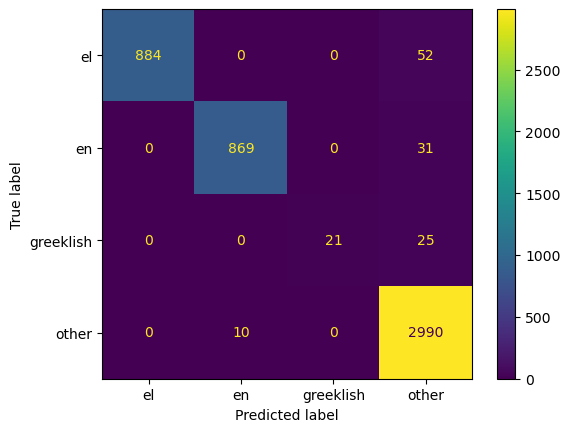

In [48]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

get_statistics(y_test, lr_res)

In [49]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=50, 
                                      n_jobs=-1, 
                                      criterion="entropy")
res = cross_val_res(forest_model, x_train, y_train, cv=3)
print(f"Random Forest mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=100, 
                                      n_jobs=-1, 
                                      criterion="entropy", 
                                      verbose=1).fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
get_statistics(y_test, forest_pred)

### Adaboost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=50)
res = cross_val_res(ada_model, x_train, y_train, cv=3)
print(f"AdaBoost mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

In [ ]:
ada_model = AdaBoostClassifier(n_estimators=100).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
get_statistics(y_test, ada_pred)

In [ ]:
missed = y_test != ada_pred
pd.DataFrame({"predicted": ada_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

In [ ]:
missed = y_test != forest_pred
pd.DataFrame({"predicted": forest_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

In [ ]:
print(f"Notebook executed in {int((time()-start)// 60)} minutes and {(time()-start) % 60:.1f} seconds")